<a href="https://colab.research.google.com/github/19K41A05G3/NLP/blob/main/AESNLP(PR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/OSNLP.csv',encoding="ISO-8859-1")
X

,iD,Response,Reviewer-1,Reviewer-2,word choice,Organization
0,1,An operating system (OS) is system software th...,4,4,3.0,1.0
1,1,An operating system is the most important soft...,5,5,2.0,3.0
2,1,Collection of programs that manages hardware r...,2,1,1.0,1.0
3,1,It is an interface user and machine(hardware),2,1,1.0,0.0
4,1,An operating system is a software which acts a...,3,2,2.0,1.0
...,...,...,...,...,...,...
2385,5,Single processor contains only one processer.w...,2,2,NaN,NaN
2386,5,Single processor systems are less reliable tha...,3,3,NaN,NaN
2387,5,Single processor system contains only one proc...,2,2,NaN,NaN
2388,5,Single processor can assign only one task but ...,1,1,NaN,NaN


In [ ]:
X = X.dropna(axis=1)
y = X['Reviewer-1']
print(y)

0       4
1       5
2       2
3       2
4       3
       ..
2385    2
2386    3
2387    2
2388    1
2389    2
Name: Reviewer-1, Length: 2390, dtype: int64


In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300,dropout=0.5,recurrent_dropout=0.4, input_shape=[1, 2944], return_sequences=True))
    #model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(lr=0.001),metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
import tensorflow_hub as hub

use = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
aa=[]

In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #tokennizer=PunktSentenceTokenizer(english.pickle)
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append((raw_sentence))
    #print(sentences)
    return sentences

def makeFeatureVec(words, num_features,n):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((n,num_features),dtype="float32")
    #success
    x=use(words) #length of feature vector is (16,512) and length of use is (16,128)
    y=len(x[0])
#     featureVec = np.zeros((n,num_features),dtype="float32")
    featureVec = np.zeros((n,y),dtype="float32")
    featureVec = np.add(featureVec,x).flatten() # getting error while adding vectors
    ss=num_features-y
#     print("diff=",ss)
    featureVec = np.pad(featureVec, (0,ss), 'constant', constant_values=(0, 0))
#     print("AFTER PADDING",featureVec,len(featureVec))
#     print("SHAPE",featureVec.shape)     
    #featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, num_features,aa):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features*23),dtype="float32") # creating max length feature vector having 0s
#     print(num_features*96)
    for essay in essays:
        
#         #essayFeatureVecs.insert(counter,makeFeatureVec(essay,num_features,aa[counter]))
        arr=makeFeatureVec(essay, num_features,aa[counter]).flatten() # getting error here
#         print(arr)
        ss=(num_features*23)-len(arr)
        arr1=np.pad(arr,(0,ss),'constant', constant_values=(0, 0))
#         #print(np.add(arr1,np.zeros(num_features*np.max(aa))))
        essayFeatureVecs[counter] = np.add(arr1,np.zeros((num_features*23),dtype="float"))
#         #makeFeatureVec(essay, num_features,aa[counter]).flatten()
#         #print(essayFeatureVecs[0])
        counter = counter + 1
    return essayFeatureVecs

In [ ]:
y_pred

array([[1., 1., 1.],
       [5., 5., 5.],
       [2., 2., 2.],
       ...,
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]], dtype=float32)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    #print(X_train.isna())
    train_essays = X_train['Response']
    test_essays = X_test['Response']
    y_train=y_train
    y_test=y_test
    num_features = 128
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3
    clean_train_essays = []
    clean_test_essays=[]
    #essays=train_essays
    sentences=[]
    l1=[]
    l2=[]
    for essay in train_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)
  
      #print(sentences)
    for essay in test_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)

    for essay_v in train_essays:
      l1.append(len(sent_tokenize(essay_v)))
      clean_train_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
      #print(clean_train_essays)
    a=np.array(l1)
    print(np.max(a))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, num_features,a)
    for essay_v in test_essays:
      l2.append(len(sent_tokenize(essay_v)))
      clean_test_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
    b=np.array(l2)
    testDataVecs=getAvgFeatureVecs(clean_test_essays, num_features,b)
    trainDataVecs=np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    trainDataVecs=np.reshape(trainDataVecs,(trainDataVecs.shape[0],1,trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(b)
    #print(y_train)
    X_train, X_val, y_train, y_val = train_test_split(trainDataVecs, y_train, test_size=0.2, random_state=3)
    lstm_model = get_model()
    history=lstm_model.fit(X_train, y_train, batch_size=16, epochs=50,validation_data=(X_val, y_val))
    
    #history=lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=30)
    y_pred=(lstm_model.predict(testDataVecs))
    #print(testDataVecs)
    # Save any one of the 5 models.
    if count == 6:
      break
         #lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    #print(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    
    count += 1


--------Fold 1--------

23
[ 3  1  3  1  1  3  1  3  1  4  1  5  1  2  1  1  2  1  1  2  4  1  2  2
  1  1  1  3  1  1  1  2  4  3  1  1  4  1  1  1  1  1  1  1  2  2  6  1
  4  4  2  2  1  1  1  1  1  2  1  1  2  2  1  1  2  1  1  1  1  1  1  5
  1  6  1  1  3  1  1  1  2  2  1  1  4  1  1  2  1  1  1  1  1  2  1  1
  1  1  1  1  1  1  1  1  1  1  3  1  1  2  2  2  1  1  8 10  1  3  7  5
  1  2  1  1  1  2  1  7  3  1  1  6  1  2  1  7  1  5  8  1  1  1  5  6
  1 13  1  1  1  7 10  2  1  1  9  1  1  3  3  6  3  3  1  1  2  2  1  6
  1  2  1  1  1  1  1  1  6  1  7  1  1  1  1  3  2  3  2  1  1  1  1  1
  1  2  7  1  3  1  5  1  1  3  1  1  5  2  1  6  2  1  6  2  1  1  2  5
  1  2  1  1  5  1  4  1  1  3  1  2  1  1  2  1  2  1  1  1  1  1  1  1
  2  2  2  2  1  2  2  2  1  1  1  2  1  1 16  2  1  1  2  4  4  7  4  1
  7  2  1  8  4  3  1  2  1  1  7  3  4  1  1  1  1  4  1  1  6  9  9  1
  2  2  2  7  3  1  2  1  9  1  8  1  2  2  1  1  1  2  2  4  3  3  2  1
  2  1  1  1  1  1  1  

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
96/96 [==============================] - 18s 74ms/step - loss: 1.8143 - accuracy: 0.2413 - val_loss: 0.6428 - val_accuracy: 0.2768
Epoch 2/50
96/96 [==============================] - 6s 61ms/step - loss: 0.7632 - accuracy: 0.2773 - val_loss: 0.5796 - val_accuracy: 0.2768
Epoch 3/50
96/96 [==============================] - 6s 62ms/step - loss: 0.6809 - accuracy: 0.2753 - val_loss: 0.5884 - val_accuracy: 0.2768
Epoch 4/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6516 - accuracy: 0.2760 - val_loss: 0.5542 - val_accuracy: 0.2768
Epoch 5/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6649 - accuracy: 0.2786 - val_loss: 0.5441 - val_accuracy: 0.2768
Epoch 6/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6204 - accuracy: 0.2753 - val_loss: 0.5718 - val_accuracy: 0.2768
Epoch 7/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6366 - accuracy: 0.2773 - val_loss: 0.5594 - val_accuracy: 0.2768
Epoch 8/50
9

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


96/96 [==============================] - 17s 74ms/step - loss: 1.9295 - accuracy: 0.2315 - val_loss: 0.6966 - val_accuracy: 0.2715
Epoch 2/50
96/96 [==============================] - 6s 60ms/step - loss: 0.7768 - accuracy: 0.2681 - val_loss: 0.6180 - val_accuracy: 0.2715
Epoch 3/50
96/96 [==============================] - 6s 61ms/step - loss: 0.7679 - accuracy: 0.2714 - val_loss: 0.6440 - val_accuracy: 0.2715
Epoch 4/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6933 - accuracy: 0.2727 - val_loss: 0.5442 - val_accuracy: 0.2715
Epoch 5/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6934 - accuracy: 0.2721 - val_loss: 0.5528 - val_accuracy: 0.2715
Epoch 6/50
96/96 [==============================] - 6s 62ms/step - loss: 0.6964 - accuracy: 0.2695 - val_loss: 0.6513 - val_accuracy: 0.2715
Epoch 7/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6631 - accuracy: 0.2727 - val_loss: 0.5614 - val_accuracy: 0.2715
Epoch 8/50
96/96 [=====

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


96/96 [==============================] - 17s 72ms/step - loss: 1.9493 - accuracy: 0.2374 - val_loss: 0.7073 - val_accuracy: 0.2428
Epoch 2/50
96/96 [==============================] - 6s 60ms/step - loss: 0.7834 - accuracy: 0.2865 - val_loss: 0.6872 - val_accuracy: 0.2428
Epoch 3/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6896 - accuracy: 0.2858 - val_loss: 0.6605 - val_accuracy: 0.2428
Epoch 4/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6991 - accuracy: 0.2871 - val_loss: 0.6499 - val_accuracy: 0.2428
Epoch 5/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6688 - accuracy: 0.2884 - val_loss: 0.6927 - val_accuracy: 0.2428
Epoch 6/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6596 - accuracy: 0.2858 - val_loss: 0.6619 - val_accuracy: 0.2428
Epoch 7/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6246 - accuracy: 0.2884 - val_loss: 0.6940 - val_accuracy: 0.2428
Epoch 8/50
96/96 [=====

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


96/96 [==============================] - 16s 73ms/step - loss: 1.8171 - accuracy: 0.2276 - val_loss: 0.7899 - val_accuracy: 0.2898
Epoch 2/50
96/96 [==============================] - 6s 60ms/step - loss: 0.7419 - accuracy: 0.2727 - val_loss: 0.6970 - val_accuracy: 0.2898
Epoch 3/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6898 - accuracy: 0.2747 - val_loss: 0.6605 - val_accuracy: 0.2898
Epoch 4/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6885 - accuracy: 0.2767 - val_loss: 0.6674 - val_accuracy: 0.2898
Epoch 5/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6502 - accuracy: 0.2721 - val_loss: 0.6723 - val_accuracy: 0.2898
Epoch 6/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6690 - accuracy: 0.2773 - val_loss: 0.6503 - val_accuracy: 0.2898
Epoch 7/50
96/96 [==============================] - 6s 60ms/step - loss: 0.6374 - accuracy: 0.2767 - val_loss: 0.6545 - val_accuracy: 0.2898
Epoch 8/50
96/96 [=====

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


96/96 [==============================] - 17s 73ms/step - loss: 1.8065 - accuracy: 0.2387 - val_loss: 0.7279 - val_accuracy: 0.2689
Epoch 2/50
96/96 [==============================] - 6s 60ms/step - loss: 0.7477 - accuracy: 0.2865 - val_loss: 0.6903 - val_accuracy: 0.2689
Epoch 3/50
96/96 [==============================] - 6s 60ms/step - loss: 0.7012 - accuracy: 0.2884 - val_loss: 0.6074 - val_accuracy: 0.2689
Epoch 4/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6632 - accuracy: 0.2910 - val_loss: 0.6153 - val_accuracy: 0.2689
Epoch 5/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6649 - accuracy: 0.2891 - val_loss: 0.6478 - val_accuracy: 0.2689
Epoch 6/50
96/96 [==============================] - 6s 61ms/step - loss: 0.6188 - accuracy: 0.2904 - val_loss: 0.6167 - val_accuracy: 0.2689
Epoch 7/50
96/96 [==============================] - 6s 62ms/step - loss: 0.6237 - accuracy: 0.2891 - val_loss: 0.6328 - val_accuracy: 0.2689
Epoch 8/50
96/96 [=====

In [ ]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=3))

Average Kappa score after a 5-fold cross validation:  0.692


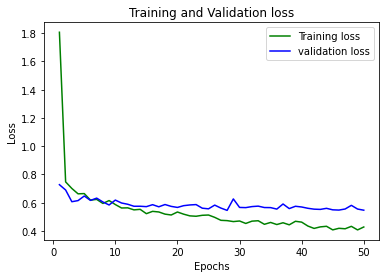

In [ ]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

2       2
3       2
4       3
5       1
18      3
       ..
2371    1
2373    2
2376    1
2377    1
2382    1
Name: Reviewer-1, Length: 478, dtype: int64


ValueError: ignored

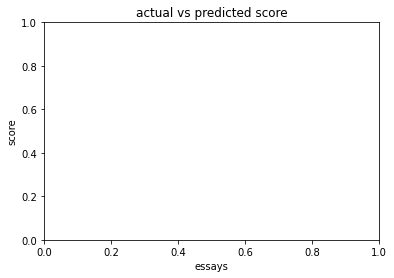

In [ ]:
print(y_test)
import matplotlib.pyplot as plt
x=np.arange(0,62)
plt.title("actual vs predicted score")
plt.xlabel("essays")
plt.ylabel("score")

plt.scatter(x,y_test.values,color='r',label="actual score")
plt.scatter(x,y_pred,color='b',label="predicted score")
plt.tight_layout()
plt.show()
